# Quantum Fourier Transform

### Import section

In [28]:
import numpy as np
from math import pi

from qiskit import *
from qiskit_aer import QasmSimulator, UnitarySimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_runtime import *

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Example on 3 qubits

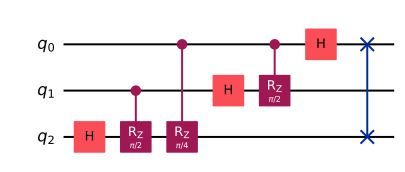

In [2]:
qc = QuantumCircuit(3)

# remember that qiskit least significant bit has the lowest index (0, not n-1)
qc.h(2)
qc.crz(pi/2,1,2)
qc.crz(pi/4,0,2)

qc.h(1)
qc.crz(pi/2,0,1)

qc.h(0)

qc.swap(0,2)
qc.draw('mpl')

### General QFT function

In [14]:
def qft_blocks(circ,n):
    if n == 0:  # exit if empty circuit
        return circ
    n -= 1    # ind start from 0
    circ.h(n)  # H gate to the most significant bit
    for k in range(n):
        # for each less significant bit a smaller angle C-phi
        circ.crz(pi/2**(n-k),k,n)
    # we recall the same function at the end on the next qubit (recursion)
    qft_blocks(circ,n)

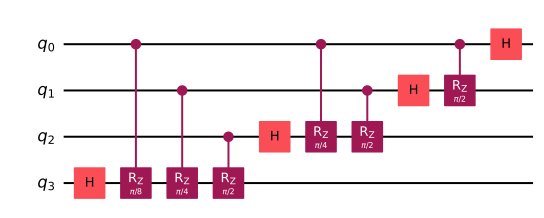

In [15]:
# Let's have a look to the circuit
n = 4
qc = QuantumCircuit(n)

qft_blocks(qc,n)
qc.draw('mpl')

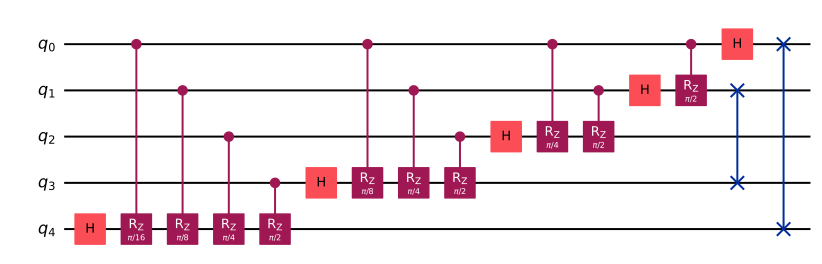

In [19]:
# we still miss swaps

def swap_registers(circ,n):
    for k in range(n//2):
        circ.swap(k,n-k-1)
    return circ

def qft(circ,n):
    # QFT on the first n qubits in the circuit (merge of the 2 functions)
    qft_blocks(circ,n)
    swap_registers(circ,n)
    return circ

n = 5
qc = QuantumCircuit(n)
qft(qc,n)
qc.draw('mpl')

### We now check if it produces correct results

In [6]:
bin(5)

'0b101'

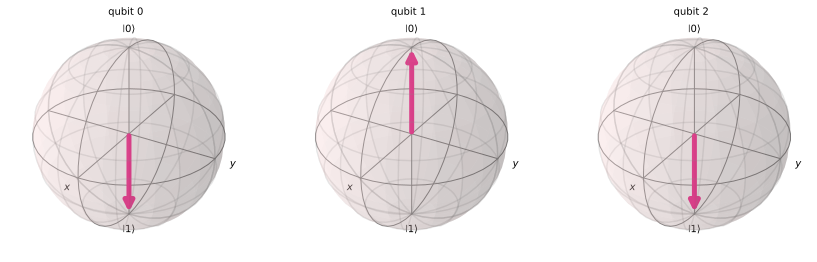

In [20]:
# we encode the state 5, 101 in binary
qc = QuantumCircuit(3)
qc.x(0)
qc.x(2)

backend = StatevectorSimulator()
statevector = backend.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

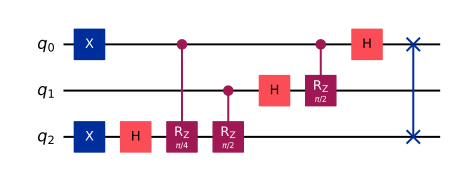

In [21]:
qft(qc,3)
qc.draw('mpl')

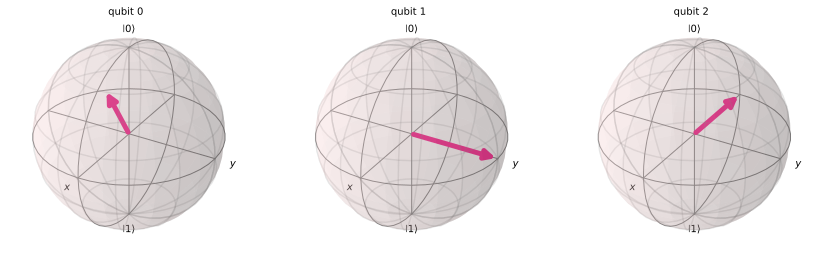

In [22]:
backend = StatevectorSimulator()
statevector = backend.run(qc.decompose()).result().get_statevector()
plot_bloch_multivector(statevector)

### Let's now run it on the hardware

In [23]:
# we define the inverse QFT to get back the original input
# otherwise we would need state tomography to check the result

def inv_qft(circ,n):
    qft_circ = qft(QuantumCircuit(n),n)
    # we take the inverse of the QFT circuit
    inv_qft_circ = qft_circ.inverse()
    # we append the inverse to the circuit
    circ.append(inv_qft_circ,circ.qubits[:n])
    
  #  return circ
# this returns the whole circuit 
    return circ.decompose()

#### Prepare input for inverse QFT $| \tilde{5}\rangle$

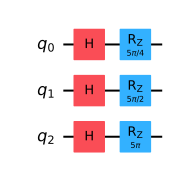

In [24]:
n_q = 3 # number of qubits
num = 5 # input number for QFT^-1
qc = QuantumCircuit(n_q)

# prepare input state 
for iq in range(n_q):
    qc.h(iq)
    
qc.rz(num*pi/4,0)
qc.rz(num*pi/2,1)
qc.rz(num*pi,2)

qc.draw('mpl')

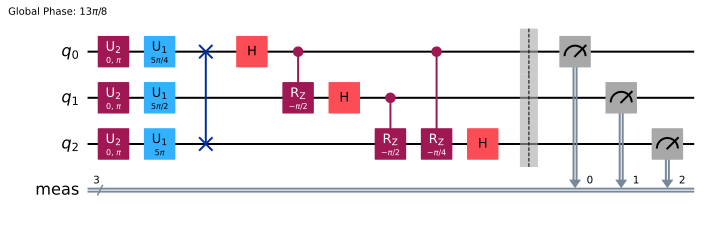

In [25]:
# we append the inverse QFT to the initialization part
qc = inv_qft(qc,n_q)

qc.measure_all()

qc.draw('mpl')

In [29]:
service = QiskitRuntimeService(channel='ibm_quantum',token='306055f5468349ef546991ac6e3b356f40d9190d9b50bf98b793de3cd71cd832d3eca2174ee7ed24e743ec7c1685550b13a7ddfabc01501d55b5030019a760ee')
service.backends()


[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_oslo')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>]

In [32]:
#backend = service.least_busy(simulator=False,operational=True)
backend = service.backend('ibm_kyoto')

job = backend.run(qc.decompose(),shots = 8192)

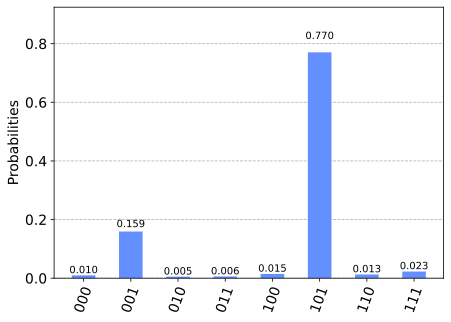

gates =  OrderedDict([('u2', 3), ('u1', 3), ('h', 3), ('crz', 3), ('measure', 3), ('swap', 1), ('barrier', 1)])
depth =  10


In [17]:
counts = job.result().get_counts()
display(plot_histogram(counts))

print('gates = ', qc.count_ops())
print('depth = ', qc.depth())

In [41]:
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

device = service.backend('ibm_kyoto')

#optimized_0 = transpile(qc, backend=device, seed_transpiler=11, optimization_level=0)
optimized = transpile(qc.decompose(), backend=device,  optimization_level = 2)

print('gates = ', optimized.count_ops())
print('depth = ', optimized.depth())

#optimized.draw('mpl')

gates =  OrderedDict([('rz', 33), ('sx', 25), ('ecr', 12), ('x', 3), ('measure', 3), ('barrier', 1)])
depth =  49


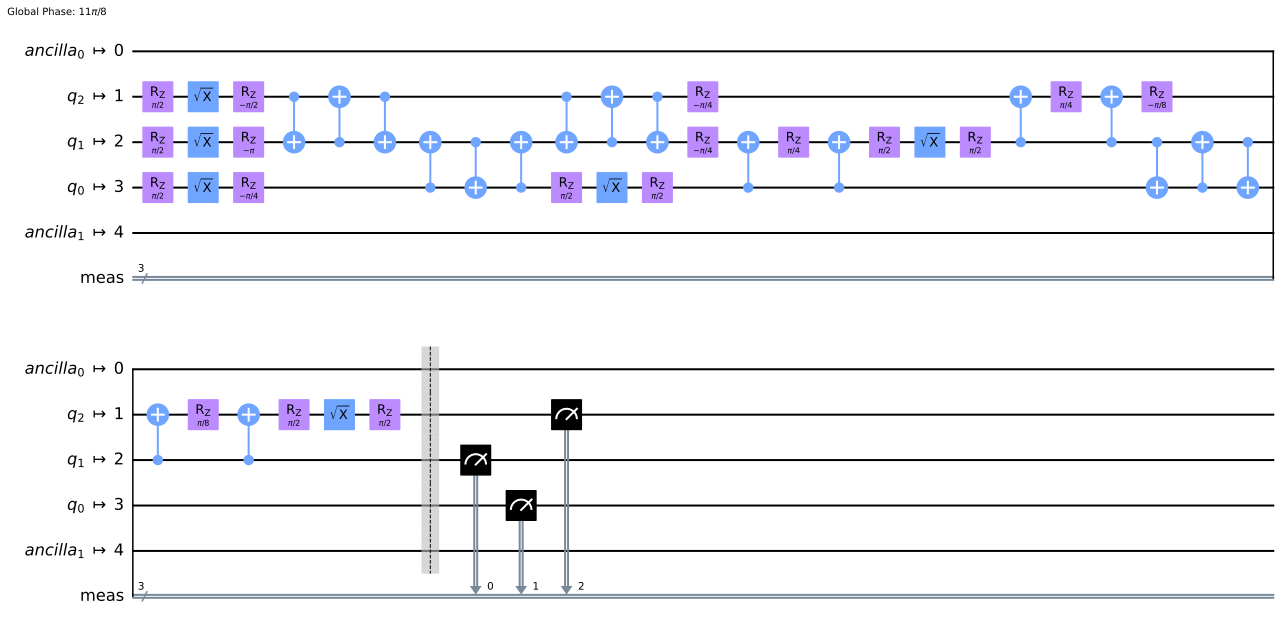

In [39]:
optimized.draw('mpl')

#### We (hopefully) see that the highest probability outcome is 101, i.e. 5 in binary

### We now try to produce the identity circuit by appending inv QFT to QFT

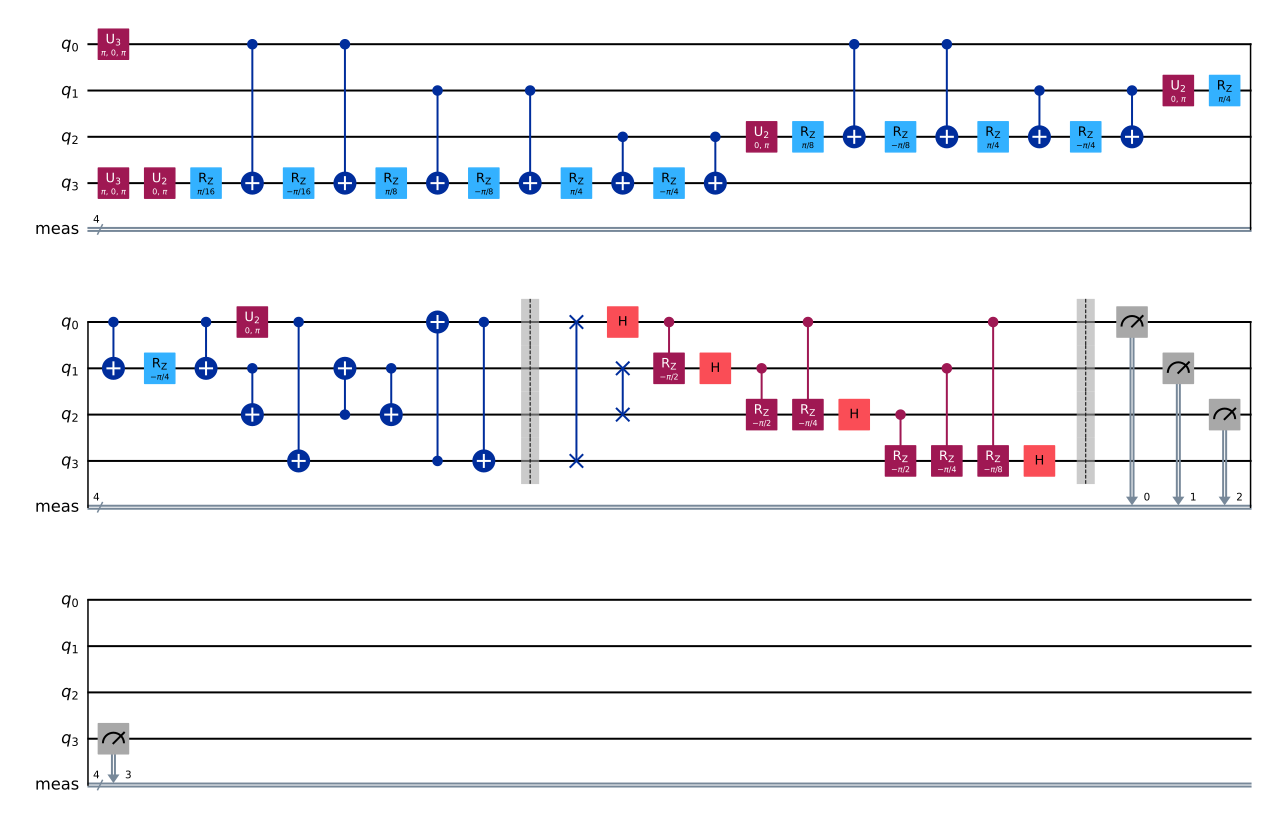

In [42]:
n_q = 4
qc = QuantumCircuit(n_q)

num = 9 # input

# initialize num in binary, i.e. 1001
qc.x(0)
qc.x(3)

qft(qc,n_q)
qc.barrier()
qc = inv_qft(qc,n_q)

qc.measure_all()

qc.draw('mpl')